# $k$-armed Bandit Problem

![Multi-armed bandit](https://miro.medium.com/max/1400/1*5q0Mihf29fftuXpKWWX2uA.png)

> You are faced repeatedly with a choice among
k di↵erent options, or actions. After each choice you receive a numerical reward chosen
from a stationary probability distribution that depends on the action you selected. Your
objective is to maximize the expected total reward over some time period, for example,
over 1000 action selections, or time steps.

You have a set of actions which provide stochastic rewards when taken. There is no "state" in the traditional RL problem sense. You merely have to evaluate and choose the best action as often as you can, while taking time to explore.

The _value_ of any action in this setup is the expected return of that action when taken.

$$
q_*(a) = \mathbb{E}[R_t \mid A_t = a ]
$$

The optimal action is the one for which $q_*(a)$ is highest. Selecting the action which currently has the highest estimated value is acting greedily, i.e _exploiting_ your knowledge rather than _exploring_ for new knowledge.

## Action Value methods

In action value methods, we form an estimate of the value of each action, $Q_t(a)$. The most natural way of doing this is to simply take the average reward for each action.

$$
Q_t(a) \quad \dot{=} \quad \frac{\sum_{i=1}^{t-1}{R_i \mathbb{1}_{A_i=a}}}{\sum_{i=1}^{t-1}{\mathbb{1}_{A_i=a}}}
$$

If we have never taken an action before, however, we use a default action value estimate, such as $0$.

Given our estimates, the greedy move is to always take the action $A_t = argmax_a{Q_t(a)}$. However, in order to explore to further refine our value estimates $Q_t(a)$, we can augment this somewhat by choosing the greedy action only with probability $1 - \epsilon, \epsilon > 0$. This is known as an $\epsilon$-greedy strategy. As the total number of actions that we can take approaches infinity, we will visit every action infinitely often, and so therefore:

$$
\lim{Q_t(a)} = q_*(a) = \mathbb{E}[R_t \mid A_t = a ]
$$

And so, eventually, we will always take the actually best action with $1-\epsilon$ probability.

_Exercise 2.1_
> In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon = 0.5$, what is the probability that the greedy action is selected?

Let $U \sim \mathcal{U}[0, 1]$.

$$
P(A_t = a_\mathrm{greedy}) = P(A_t = a_\mathrm{greedy} \mid U < \epsilon)P(U < \epsilon) + P(A_t = a_\mathrm{greedy} \mid U \ge \epsilon) P(U \ge \epsilon) \\
= \frac{1}{N}\epsilon + 1 (1-\epsilon) \\
= 1 - \frac{N-1}{N}\epsilon \\
= 1 - \frac{1}{2}0.5 = 0.75
$$

## The 10-armed Testbed

_Exercise 2.2: Bandit Example_
> Consider a $k$-armed bandit problem with $k = 4$ actions, denoted 1, 2, 3, and 4. Consider applying to this problem a bandit algorithm using $\varepsilon$-greedy action selection, sample-average action-value estimates, and initial estimates of $Q_1(a) = 0$, for all $a$. Suppose the initial sequence of actions and rewards is $A_1 = 1, R_1 = 1, A_2 = 2, R_2 = 1, A_3 = 2, R_3 = 2, A_4 = 2, R_4 = 2, A_5 = 3, R_5 = 0$. On some of these time steps the $\varepsilon$ case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?



| T | A | R |Q(1)|Q(2)|Q(3)|Q(4)|Definitely Random|Possibly Random
|---|---|---|---|---|---|---|---|---
| 1 | 1 | 1 | 1 | 0 | 0 | 0 | ❌ | ✅
| 2 | 2 | 1 | 1 | 1 | 0 | 0 | ✅ | ✅
| 3 | 2 | 2 | 1 | 1.5 | 0 | 0 | ❌ | ✅
| 4 | 2 | 2 | 1 | 1.66 | 0 | 0 | ❌ | ✅
| 5 | 3 | 0 | 1 | 1.66 | 0 | 0 | ✅ | ✅



_Exercise 2.3_
> In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively

After some sufficiently long period of time, the $\varepsilon = 0.01$ will outperform the other two methods. Specifically, it will eventually pick the optimal action $1-\varepsilon = 0.99 = 99\%$ of the time, while the $\varepsilon = 0.1$ will eventually pick the optimal action $1-\varepsilon = 0.9 = 90\%$ of the time. The $\varepsilon = 0$ case will not necessarily converge to correctly picking the correct action with any probability. Instead, the probability that the greedy method converges to the optimal action is ...

For any given bandit problem with mean vector $\mathbf{\mu} \in \mathbb{R}^{10}$, the long term expected reward per action of an $\varepsilon$ greedy strategy will be $(1-\varepsilon)\max \mu$. Taking the ratio of this term for $\varepsilon = 0.99$ and $\varepsilon = 0.9$, we can see that the average reward per action of for $\varepsilon = 0.99$ will be $\frac{0.99\max \mu}{0.9\max \mu} = 1.1$ times larger than the average reward per action of $\varepsilon = 0.9$. Since the average reward per action determines the rate of growth of $\sum_{t=0}^T{R_t}$, we can infer then that $1.1$ is the asymptotic ratio between the reward for each of these two values of $\varepsilon$

Furthermore, if we assume we draw $k$-armed bandit problems from the distribution described in the chapter, we can estimate the average optimal action as

In [153]:
max_μ = mean([maximum(randn(10)) for _ in 1:10000000])

1.5391407817761975

And therefore calculate the long term expected value per action as for $\varepsilon = 0.99, 0.9$ as

In [155]:
(0.99 * max_μ, 0.9 * max_μ)

(1.5237493739584356, 1.3852267035985777)

### Implementation of Bandit Algorithm

In [125]:
using Distributions
using Plots

function bandit_problem(k)
    mean_distribution = Normal(0, 1)
    means = rand(mean_distribution, k)
    return Normal.(means, 1)
end

problems = [ bandit_problem(10) for _ in 1:2000 ];

function ε_greedy(;k=10, ε=0.01)
    q_s = zeros(k)
    n_s = zeros(k)
    return function(dist)
        action = rand() < ε ? rand(1:k) : argmax(q_s)
        reward = dist(action)
        n_s[action] += 1
        q_s[action] += (1/n_s[action]) * (reward - q_s[action])
        return reward, action
    end
end

ε_greedy (generic function with 1 method)

In [95]:
rewards = Dict{Float64,Array{Float64,2}}()
actions = Dict{Float64,Array{Float64,2}}()
agents = Dict{Float64,Array{Function,1}}()

for ε in [0, 0.1, 0.01]
    rewards[ε] = Array{Float64,2}(undef, 1000, 2000)
    actions[ε] = Array{Float64,2}(undef, 1000, 2000)
    agents[ε] = []
    for (i, problem) in enumerate(problems)
        agent = ε_greedy(;k=10, ε=ε)
        dist(a) = rand(problem[a])
        new_rewards = []
        new_actions = []
        for j in 1:1000
            r, a = agent(dist)
            push!(new_rewards, r)
            push!(new_actions, a)
        end
        actions[ε][:,i] = new_actions
        rewards[ε][:,i] = new_rewards
        push!(agents[ε], agent)
    end
end

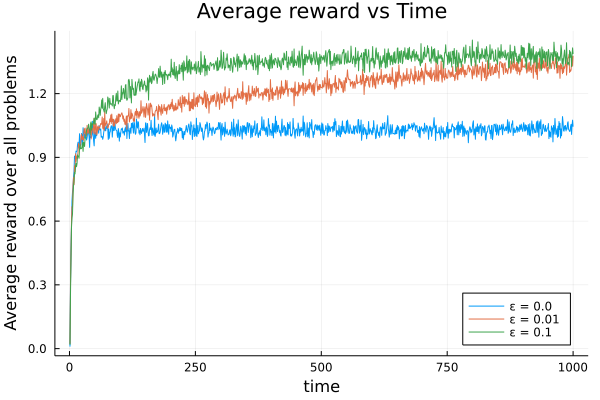

In [122]:
plot(
    [ mean(rewards[0.0], dims=2) mean(rewards[0.01], dims=2) mean(rewards[0.1], dims=2) ],
    label=["ε = 0.0" "ε = 0.01" "ε = 0.1"],
    xlabel="time",
    ylabel="Average reward over all problems",
    legend=:bottomright,
    title="Average reward vs Time"
)

In [123]:
optimal_actions = [ argmax([action.μ for action in problem]) for problem in problems]
optimal_action_matrix = repeat(optimal_actions', 1000);

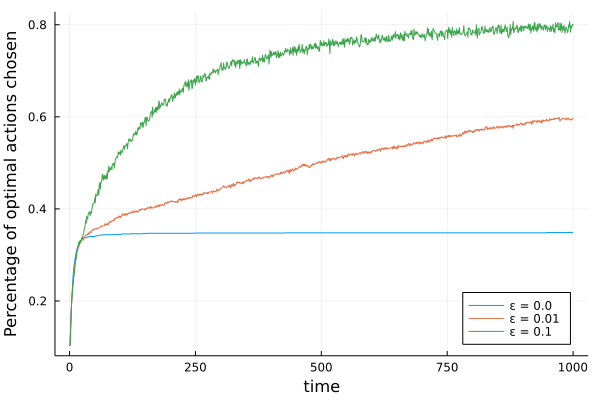

In [124]:
plot(
    [ mean(actions[ε] .== optimal_action_matrix, dims=2) for ε in [0.0, 0.01, 0.1] ],
    label=["ε = 0.0" "ε = 0.01" "ε = 0.1"],
    xlabel="time",
    ylabel="Percentage of optimal actions chosen",
    legend=:bottomright
)

In [117]:
action_values = hcat(map(p -> getfield.(p, :μ), problems)...);

In [118]:
[ε => mean((hcat(getfield.(agents[ε], :q_s)...) - action_values).^2) for ε in [0.0, 0.01, 0.1]]

3-element Vector{Pair{Float64, Float64}}:
  0.0 => 0.8650205892491533
 0.01 => 0.6033753559375111
  0.1 => 0.08656105257691757

_Exercise 2.4_
> If the step-size parameters, $\alpha_n$, are not constant, then the estimate $Q_n$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?

$$
Q_{n+1} = \prod_{i=1}^n{(1-\alpha(i))} + \sum_{i=1}^n{\alpha(i)R_i \prod_{j=1}^n{1-\alpha(j)}}
$$

And therefore, the "weight" on reward $i$ becomes

$$
W_i = \alpha(i)\prod_{j=1}^n{1-\alpha(j)}
$$

_Exercise 2.5_
> Design and conduct an experiment to demonstrate the diculties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\varepsilon = 0.1$ and longer runs, say of 10,000 steps.

In [158]:
Normal(0.0,0.01)

Normal{Float64}(μ=0.0, σ=0.01)

In [170]:
function ε_greedy_ns(;k=10, ε=0.01, α=n->1/n)
    q_s = zeros(k)
    n_s = zeros(k)
    return function(dist)
        action = rand() < ε ? rand(1:k) : argmax(q_s)
        reward = rand(dist(action))
        n_s[action] += 1
        q_s[action] += α(n_s[action]) * (reward - q_s[action])
        return reward, action
    end
end

ε_greedy_ns (generic function with 1 method)

In [191]:
function evaluate(problems; ε, α, T)
    rewards = Array{Float64,2}(undef, T, 2000)
    actions = Array{Float64,2}(undef, T, 2000)
    for (i, problem) in enumerate(problems)
        agent = ε_greedy_ns(;k=10, ε=ε, α=α)
        dist(a) = problem[a]
        new_rewards = []
        new_actions = []
        for j in 1:T
            r, a = agent(dist)
            push!(new_rewards, r)
            push!(new_actions, a)
            for i in eachindex(problem)
                problem[i] = Normal(problem[i].μ + rand(Normal(0, 0.01)), 1)
            end
        end
        actions[:,i] = new_actions
        rewards[:,i] = new_rewards
    end
    return actions, rewards
end

evaluate (generic function with 3 methods)

In [192]:
problems_ns = [ bandit_problem(10) for _ in 1:2000 ];
const_α_actions, const_α_rewards = evaluate(problems_ns; ε=0.1, α=n->0.1, T=10_000);

In [193]:
problems_ns = [ bandit_problem(10) for _ in 1:2000 ];
av_actions, av_rewards = evaluate(problems_ns; ε=0.1, α=n->1/n, T=10_000);

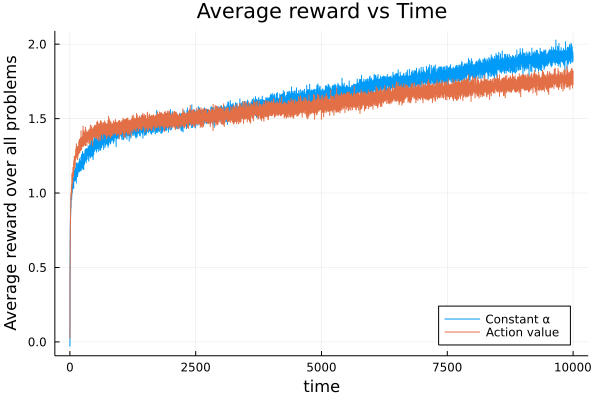

In [194]:
plot(
    [ mean(const_α_rewards, dims=2) mean(av_rewards, dims=2) ],
    label=["Constant α" "Action value"],
    xlabel="time",
    ylabel="Average reward over all problems",
    legend=:bottomright,
    title="Average reward vs Time"
)